In [2]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
import sys
import matplotlib.pyplot as plt

In [7]:

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\rajpa\Anaconda3\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.683940, acc.: 45.31%] [G loss: 0.514574]


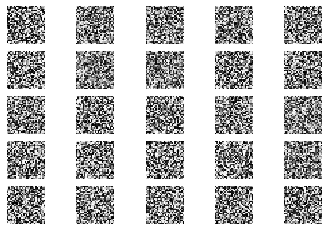

C:\Users\rajpa\Anaconda3\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.606328, acc.: 56.25%] [G loss: 0.598696]
2 [D loss: 0.463742, acc.: 62.50%] [G loss: 0.737190]
3 [D loss: 0.360292, acc.: 84.38%] [G loss: 0.863808]
4 [D loss: 0.280496, acc.: 92.19%] [G loss: 1.079124]
5 [D loss: 0.251375, acc.: 98.44%] [G loss: 1.169027]
6 [D loss: 0.259383, acc.: 95.31%] [G loss: 1.233316]
7 [D loss: 0.228719, acc.: 98.44%] [G loss: 1.424331]
8 [D loss: 0.184440, acc.: 98.44%] [G loss: 1.514746]
9 [D loss: 0.147961, acc.: 100.00%] [G loss: 1.531380]
10 [D loss: 0.141471, acc.: 100.00%] [G loss: 1.780491]
11 [D loss: 0.126469, acc.: 100.00%] [G loss: 1.864552]
12 [D loss: 0.119539, acc.: 100.00%] [G loss: 1.744787]
13 [D loss: 0.106760, acc.: 100.00%] [G loss: 1.796572]
14 [D loss: 0.101955, acc.: 100.00%] [G loss: 2.041152]
15 [D loss: 0.088793, acc.: 100.00%] [G loss: 2.032989]
16 [D loss: 0.080361, acc.: 100.00%] [G loss: 2.153090]
17 [D loss: 0.087987, acc.: 100.00%] [G loss: 2.168947]
18 [D loss: 0.075565, acc.: 100.00%] [G loss: 2.277841]
19 [D los

151 [D loss: 0.223978, acc.: 89.06%] [G loss: 4.009197]
152 [D loss: 0.446502, acc.: 78.12%] [G loss: 3.745200]
153 [D loss: 0.093842, acc.: 98.44%] [G loss: 4.239337]
154 [D loss: 0.187571, acc.: 95.31%] [G loss: 4.028098]
155 [D loss: 0.212813, acc.: 95.31%] [G loss: 4.191255]
156 [D loss: 0.180337, acc.: 93.75%] [G loss: 3.457865]
157 [D loss: 0.233116, acc.: 90.62%] [G loss: 4.051655]
158 [D loss: 0.120333, acc.: 98.44%] [G loss: 3.702771]
159 [D loss: 0.289670, acc.: 90.62%] [G loss: 3.987703]
160 [D loss: 0.159111, acc.: 93.75%] [G loss: 4.409979]
161 [D loss: 0.498014, acc.: 79.69%] [G loss: 3.592849]
162 [D loss: 0.327766, acc.: 90.62%] [G loss: 3.754673]
163 [D loss: 0.239794, acc.: 87.50%] [G loss: 3.885179]
164 [D loss: 0.312157, acc.: 84.38%] [G loss: 3.906779]
165 [D loss: 0.227884, acc.: 92.19%] [G loss: 3.581448]
166 [D loss: 0.211217, acc.: 89.06%] [G loss: 3.362561]
167 [D loss: 0.101592, acc.: 98.44%] [G loss: 3.727662]
168 [D loss: 0.697142, acc.: 67.19%] [G loss: 3.

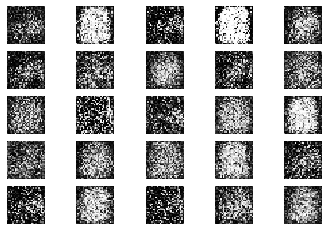

201 [D loss: 0.237499, acc.: 89.06%] [G loss: 3.364344]
202 [D loss: 0.445794, acc.: 78.12%] [G loss: 3.426037]
203 [D loss: 0.712910, acc.: 76.56%] [G loss: 2.382298]
204 [D loss: 0.451687, acc.: 81.25%] [G loss: 2.596937]
205 [D loss: 0.462159, acc.: 81.25%] [G loss: 2.231892]
206 [D loss: 0.530077, acc.: 73.44%] [G loss: 2.537422]
207 [D loss: 0.536029, acc.: 68.75%] [G loss: 2.708796]
208 [D loss: 0.241377, acc.: 92.19%] [G loss: 3.121681]
209 [D loss: 0.505571, acc.: 75.00%] [G loss: 2.987947]
210 [D loss: 0.473887, acc.: 81.25%] [G loss: 2.450207]
211 [D loss: 0.432524, acc.: 79.69%] [G loss: 2.109513]
212 [D loss: 0.218418, acc.: 92.19%] [G loss: 2.998123]
213 [D loss: 0.487032, acc.: 71.88%] [G loss: 2.682676]
214 [D loss: 0.327827, acc.: 85.94%] [G loss: 2.775227]
215 [D loss: 0.492200, acc.: 79.69%] [G loss: 2.480848]
216 [D loss: 0.365000, acc.: 82.81%] [G loss: 2.663565]
217 [D loss: 0.511955, acc.: 84.38%] [G loss: 2.779577]
218 [D loss: 0.391796, acc.: 81.25%] [G loss: 2.

349 [D loss: 0.716748, acc.: 56.25%] [G loss: 0.942348]
350 [D loss: 0.747264, acc.: 53.12%] [G loss: 0.959853]
351 [D loss: 0.692548, acc.: 59.38%] [G loss: 0.934360]
352 [D loss: 0.624022, acc.: 67.19%] [G loss: 0.936278]
353 [D loss: 0.698699, acc.: 64.06%] [G loss: 0.880698]
354 [D loss: 0.681164, acc.: 56.25%] [G loss: 0.862011]
355 [D loss: 0.693856, acc.: 59.38%] [G loss: 0.873651]
356 [D loss: 0.668831, acc.: 57.81%] [G loss: 0.884676]
357 [D loss: 0.647856, acc.: 64.06%] [G loss: 0.985035]
358 [D loss: 0.657551, acc.: 64.06%] [G loss: 1.017256]
359 [D loss: 0.657460, acc.: 64.06%] [G loss: 0.933161]
360 [D loss: 0.779074, acc.: 50.00%] [G loss: 0.938477]
361 [D loss: 0.587945, acc.: 65.62%] [G loss: 0.991174]
362 [D loss: 0.665466, acc.: 60.94%] [G loss: 1.001011]
363 [D loss: 0.680976, acc.: 62.50%] [G loss: 0.934303]
364 [D loss: 0.676038, acc.: 60.94%] [G loss: 0.862860]
365 [D loss: 0.636869, acc.: 70.31%] [G loss: 0.882957]
366 [D loss: 0.638046, acc.: 65.62%] [G loss: 0.

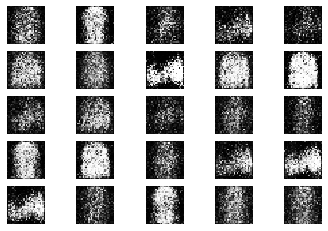

401 [D loss: 0.656525, acc.: 62.50%] [G loss: 0.922876]
402 [D loss: 0.641822, acc.: 65.62%] [G loss: 0.997811]
403 [D loss: 0.645418, acc.: 60.94%] [G loss: 0.906066]
404 [D loss: 0.626314, acc.: 68.75%] [G loss: 0.888067]
405 [D loss: 0.658832, acc.: 65.62%] [G loss: 0.933565]
406 [D loss: 0.616479, acc.: 78.12%] [G loss: 0.932903]
407 [D loss: 0.617174, acc.: 75.00%] [G loss: 1.012116]
408 [D loss: 0.615535, acc.: 67.19%] [G loss: 0.954835]
409 [D loss: 0.606314, acc.: 70.31%] [G loss: 0.961492]
410 [D loss: 0.596337, acc.: 65.62%] [G loss: 0.980130]
411 [D loss: 0.689749, acc.: 62.50%] [G loss: 0.989759]
412 [D loss: 0.635512, acc.: 62.50%] [G loss: 0.932578]
413 [D loss: 0.659353, acc.: 59.38%] [G loss: 0.905357]
414 [D loss: 0.619876, acc.: 70.31%] [G loss: 0.905637]
415 [D loss: 0.629046, acc.: 62.50%] [G loss: 0.921100]
416 [D loss: 0.586717, acc.: 70.31%] [G loss: 0.934878]
417 [D loss: 0.583864, acc.: 71.88%] [G loss: 0.912539]
418 [D loss: 0.572375, acc.: 70.31%] [G loss: 0.

551 [D loss: 0.592489, acc.: 73.44%] [G loss: 1.029702]
552 [D loss: 0.649851, acc.: 64.06%] [G loss: 0.959620]
553 [D loss: 0.671243, acc.: 57.81%] [G loss: 0.916398]
554 [D loss: 0.595530, acc.: 75.00%] [G loss: 0.964562]
555 [D loss: 0.621267, acc.: 64.06%] [G loss: 0.980672]
556 [D loss: 0.647126, acc.: 67.19%] [G loss: 0.934189]
557 [D loss: 0.651478, acc.: 71.88%] [G loss: 0.972357]
558 [D loss: 0.609256, acc.: 68.75%] [G loss: 0.919765]
559 [D loss: 0.649547, acc.: 67.19%] [G loss: 0.891680]
560 [D loss: 0.596358, acc.: 73.44%] [G loss: 0.889915]
561 [D loss: 0.596456, acc.: 65.62%] [G loss: 0.872645]
562 [D loss: 0.633899, acc.: 65.62%] [G loss: 1.009720]
563 [D loss: 0.635920, acc.: 62.50%] [G loss: 0.969569]
564 [D loss: 0.628953, acc.: 60.94%] [G loss: 0.859631]
565 [D loss: 0.657966, acc.: 59.38%] [G loss: 0.873866]
566 [D loss: 0.624788, acc.: 64.06%] [G loss: 0.929907]
567 [D loss: 0.673744, acc.: 60.94%] [G loss: 0.975284]
568 [D loss: 0.666174, acc.: 57.81%] [G loss: 0.

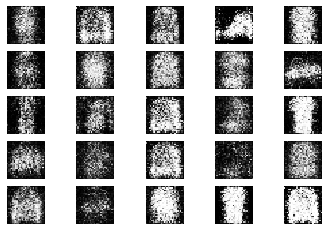

601 [D loss: 0.691847, acc.: 48.44%] [G loss: 0.879142]
602 [D loss: 0.591069, acc.: 73.44%] [G loss: 0.877476]
603 [D loss: 0.616604, acc.: 68.75%] [G loss: 0.904951]
604 [D loss: 0.646730, acc.: 64.06%] [G loss: 0.903257]
605 [D loss: 0.605500, acc.: 64.06%] [G loss: 0.954089]
606 [D loss: 0.638296, acc.: 56.25%] [G loss: 0.860783]
607 [D loss: 0.695251, acc.: 65.62%] [G loss: 0.859069]
608 [D loss: 0.670530, acc.: 56.25%] [G loss: 0.807715]
609 [D loss: 0.649539, acc.: 59.38%] [G loss: 0.828714]
610 [D loss: 0.623781, acc.: 60.94%] [G loss: 0.853716]
611 [D loss: 0.636570, acc.: 70.31%] [G loss: 0.932467]
612 [D loss: 0.663955, acc.: 59.38%] [G loss: 0.887112]
613 [D loss: 0.633430, acc.: 67.19%] [G loss: 0.934038]
614 [D loss: 0.640911, acc.: 64.06%] [G loss: 0.809781]
615 [D loss: 0.603589, acc.: 65.62%] [G loss: 0.893908]
616 [D loss: 0.635560, acc.: 64.06%] [G loss: 0.904009]
617 [D loss: 0.693691, acc.: 65.62%] [G loss: 0.893070]
618 [D loss: 0.663314, acc.: 59.38%] [G loss: 0.

748 [D loss: 0.591062, acc.: 71.88%] [G loss: 0.994793]
749 [D loss: 0.688154, acc.: 56.25%] [G loss: 0.936668]
750 [D loss: 0.612790, acc.: 68.75%] [G loss: 0.876396]
751 [D loss: 0.630467, acc.: 67.19%] [G loss: 0.890490]
752 [D loss: 0.626524, acc.: 60.94%] [G loss: 0.790519]
753 [D loss: 0.672066, acc.: 60.94%] [G loss: 0.731325]
754 [D loss: 0.660535, acc.: 59.38%] [G loss: 0.851848]
755 [D loss: 0.587658, acc.: 68.75%] [G loss: 0.910769]
756 [D loss: 0.599827, acc.: 70.31%] [G loss: 0.962115]
757 [D loss: 0.678171, acc.: 51.56%] [G loss: 0.863678]
758 [D loss: 0.604130, acc.: 73.44%] [G loss: 0.907854]
759 [D loss: 0.640803, acc.: 64.06%] [G loss: 0.892006]
760 [D loss: 0.603707, acc.: 67.19%] [G loss: 0.924661]
761 [D loss: 0.661417, acc.: 59.38%] [G loss: 0.765552]
762 [D loss: 0.611051, acc.: 70.31%] [G loss: 0.872828]
763 [D loss: 0.622553, acc.: 65.62%] [G loss: 0.830668]
764 [D loss: 0.625962, acc.: 67.19%] [G loss: 0.898455]
765 [D loss: 0.604745, acc.: 73.44%] [G loss: 0.

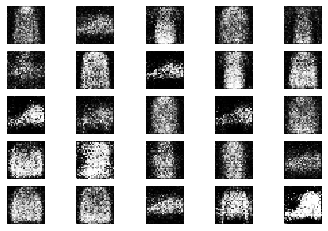

801 [D loss: 0.614680, acc.: 59.38%] [G loss: 0.890797]
802 [D loss: 0.537992, acc.: 78.12%] [G loss: 0.961308]
803 [D loss: 0.606439, acc.: 59.38%] [G loss: 0.921626]
804 [D loss: 0.640978, acc.: 57.81%] [G loss: 0.813622]
805 [D loss: 0.684909, acc.: 59.38%] [G loss: 0.855611]
806 [D loss: 0.659175, acc.: 56.25%] [G loss: 0.808133]
807 [D loss: 0.560974, acc.: 65.62%] [G loss: 0.827104]
808 [D loss: 0.567221, acc.: 68.75%] [G loss: 0.859531]
809 [D loss: 0.599975, acc.: 67.19%] [G loss: 0.926991]
810 [D loss: 0.593868, acc.: 65.62%] [G loss: 0.866845]
811 [D loss: 0.625468, acc.: 60.94%] [G loss: 0.814209]
812 [D loss: 0.658779, acc.: 60.94%] [G loss: 0.903504]
813 [D loss: 0.697122, acc.: 59.38%] [G loss: 0.868686]
814 [D loss: 0.594963, acc.: 76.56%] [G loss: 0.842664]
815 [D loss: 0.595471, acc.: 67.19%] [G loss: 0.891022]
816 [D loss: 0.620779, acc.: 67.19%] [G loss: 0.894448]
817 [D loss: 0.614704, acc.: 65.62%] [G loss: 0.884756]
818 [D loss: 0.615283, acc.: 57.81%] [G loss: 0.

951 [D loss: 0.719494, acc.: 45.31%] [G loss: 0.795271]
952 [D loss: 0.629878, acc.: 62.50%] [G loss: 0.878221]
953 [D loss: 0.606646, acc.: 67.19%] [G loss: 0.841207]
954 [D loss: 0.686418, acc.: 54.69%] [G loss: 0.781564]
955 [D loss: 0.583378, acc.: 73.44%] [G loss: 0.793966]
956 [D loss: 0.655726, acc.: 56.25%] [G loss: 0.739936]
957 [D loss: 0.680833, acc.: 57.81%] [G loss: 0.794336]
958 [D loss: 0.666225, acc.: 54.69%] [G loss: 0.799727]
959 [D loss: 0.607973, acc.: 70.31%] [G loss: 0.807120]
960 [D loss: 0.639421, acc.: 60.94%] [G loss: 0.853184]
961 [D loss: 0.604876, acc.: 71.88%] [G loss: 0.837900]
962 [D loss: 0.685473, acc.: 56.25%] [G loss: 0.770850]
963 [D loss: 0.656332, acc.: 64.06%] [G loss: 0.782756]
964 [D loss: 0.687867, acc.: 56.25%] [G loss: 0.831173]
965 [D loss: 0.597230, acc.: 75.00%] [G loss: 0.851864]
966 [D loss: 0.671744, acc.: 56.25%] [G loss: 0.777075]
967 [D loss: 0.627054, acc.: 59.38%] [G loss: 0.821014]
968 [D loss: 0.652220, acc.: 62.50%] [G loss: 0.

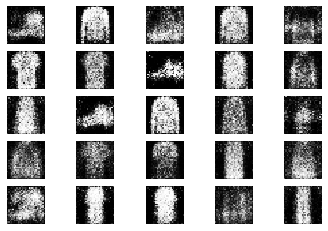

1001 [D loss: 0.728317, acc.: 48.44%] [G loss: 0.828135]
1002 [D loss: 0.592505, acc.: 71.88%] [G loss: 0.793427]
1003 [D loss: 0.666218, acc.: 56.25%] [G loss: 0.887755]
1004 [D loss: 0.659875, acc.: 56.25%] [G loss: 0.878198]
1005 [D loss: 0.672163, acc.: 54.69%] [G loss: 0.882715]
1006 [D loss: 0.702663, acc.: 51.56%] [G loss: 0.785996]
1007 [D loss: 0.661556, acc.: 62.50%] [G loss: 0.799132]
1008 [D loss: 0.649075, acc.: 60.94%] [G loss: 0.819798]
1009 [D loss: 0.650750, acc.: 62.50%] [G loss: 0.838266]
1010 [D loss: 0.616379, acc.: 64.06%] [G loss: 0.866027]
1011 [D loss: 0.700694, acc.: 51.56%] [G loss: 0.795923]
1012 [D loss: 0.621781, acc.: 65.62%] [G loss: 0.918401]
1013 [D loss: 0.660731, acc.: 60.94%] [G loss: 0.819532]
1014 [D loss: 0.652648, acc.: 60.94%] [G loss: 0.789213]
1015 [D loss: 0.593362, acc.: 70.31%] [G loss: 0.819197]
1016 [D loss: 0.675097, acc.: 54.69%] [G loss: 0.817412]
1017 [D loss: 0.651633, acc.: 60.94%] [G loss: 0.820847]
1018 [D loss: 0.647260, acc.: 6

1149 [D loss: 0.641074, acc.: 65.62%] [G loss: 0.807052]
1150 [D loss: 0.724159, acc.: 59.38%] [G loss: 0.870314]
1151 [D loss: 0.640509, acc.: 57.81%] [G loss: 0.823676]
1152 [D loss: 0.676984, acc.: 57.81%] [G loss: 0.865356]
1153 [D loss: 0.635732, acc.: 62.50%] [G loss: 0.777312]
1154 [D loss: 0.626903, acc.: 65.62%] [G loss: 0.855112]
1155 [D loss: 0.698290, acc.: 54.69%] [G loss: 0.799801]
1156 [D loss: 0.665622, acc.: 62.50%] [G loss: 0.793847]
1157 [D loss: 0.663221, acc.: 65.62%] [G loss: 0.905754]
1158 [D loss: 0.611083, acc.: 65.62%] [G loss: 0.829676]
1159 [D loss: 0.628562, acc.: 68.75%] [G loss: 0.918527]
1160 [D loss: 0.661698, acc.: 59.38%] [G loss: 0.864721]
1161 [D loss: 0.658918, acc.: 64.06%] [G loss: 0.820630]
1162 [D loss: 0.700641, acc.: 53.12%] [G loss: 0.790857]
1163 [D loss: 0.677884, acc.: 60.94%] [G loss: 0.810334]
1164 [D loss: 0.632254, acc.: 64.06%] [G loss: 0.788569]
1165 [D loss: 0.658003, acc.: 53.12%] [G loss: 0.886774]
1166 [D loss: 0.659734, acc.: 6

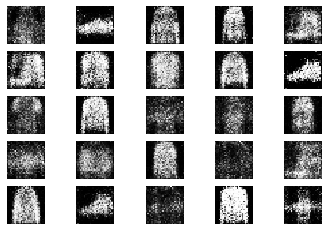

1201 [D loss: 0.574098, acc.: 73.44%] [G loss: 0.898444]
1202 [D loss: 0.678761, acc.: 54.69%] [G loss: 0.838941]
1203 [D loss: 0.627255, acc.: 62.50%] [G loss: 0.854678]
1204 [D loss: 0.637818, acc.: 62.50%] [G loss: 0.858952]
1205 [D loss: 0.716765, acc.: 54.69%] [G loss: 0.778011]
1206 [D loss: 0.655043, acc.: 62.50%] [G loss: 0.763391]
1207 [D loss: 0.640853, acc.: 59.38%] [G loss: 0.794150]
1208 [D loss: 0.679072, acc.: 62.50%] [G loss: 0.856839]
1209 [D loss: 0.691411, acc.: 51.56%] [G loss: 0.778025]
1210 [D loss: 0.640400, acc.: 65.62%] [G loss: 0.847093]
1211 [D loss: 0.604070, acc.: 70.31%] [G loss: 0.846736]
1212 [D loss: 0.706849, acc.: 53.12%] [G loss: 0.872686]
1213 [D loss: 0.634841, acc.: 62.50%] [G loss: 0.896439]
1214 [D loss: 0.612035, acc.: 68.75%] [G loss: 0.861390]
1215 [D loss: 0.568082, acc.: 82.81%] [G loss: 0.788685]
1216 [D loss: 0.617779, acc.: 67.19%] [G loss: 0.794247]
1217 [D loss: 0.649298, acc.: 59.38%] [G loss: 0.834993]
1218 [D loss: 0.650907, acc.: 6

1347 [D loss: 0.606182, acc.: 75.00%] [G loss: 0.779844]
1348 [D loss: 0.608958, acc.: 64.06%] [G loss: 0.877812]
1349 [D loss: 0.618115, acc.: 70.31%] [G loss: 0.868823]
1350 [D loss: 0.639098, acc.: 60.94%] [G loss: 0.951634]
1351 [D loss: 0.614465, acc.: 62.50%] [G loss: 0.902998]
1352 [D loss: 0.666514, acc.: 54.69%] [G loss: 0.818681]
1353 [D loss: 0.637448, acc.: 68.75%] [G loss: 0.772064]
1354 [D loss: 0.677426, acc.: 57.81%] [G loss: 0.794363]
1355 [D loss: 0.655466, acc.: 65.62%] [G loss: 0.920820]
1356 [D loss: 0.606538, acc.: 62.50%] [G loss: 0.949639]
1357 [D loss: 0.622116, acc.: 65.62%] [G loss: 0.879050]
1358 [D loss: 0.648129, acc.: 60.94%] [G loss: 0.893340]
1359 [D loss: 0.670094, acc.: 51.56%] [G loss: 0.775147]
1360 [D loss: 0.636059, acc.: 70.31%] [G loss: 0.813614]
1361 [D loss: 0.640352, acc.: 62.50%] [G loss: 0.838361]
1362 [D loss: 0.693896, acc.: 59.38%] [G loss: 0.860029]
1363 [D loss: 0.594330, acc.: 64.06%] [G loss: 0.872187]
1364 [D loss: 0.643223, acc.: 5

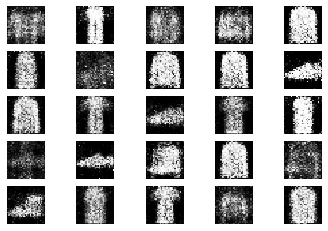

1401 [D loss: 0.615904, acc.: 70.31%] [G loss: 0.816504]
1402 [D loss: 0.676390, acc.: 59.38%] [G loss: 0.861482]
1403 [D loss: 0.676888, acc.: 59.38%] [G loss: 0.891958]
1404 [D loss: 0.699641, acc.: 54.69%] [G loss: 0.896034]
1405 [D loss: 0.619195, acc.: 68.75%] [G loss: 0.971254]
1406 [D loss: 0.574649, acc.: 75.00%] [G loss: 0.929723]
1407 [D loss: 0.685060, acc.: 59.38%] [G loss: 0.826940]
1408 [D loss: 0.639592, acc.: 68.75%] [G loss: 0.985930]
1409 [D loss: 0.691511, acc.: 62.50%] [G loss: 0.862242]
1410 [D loss: 0.585061, acc.: 73.44%] [G loss: 0.808004]
1411 [D loss: 0.627120, acc.: 67.19%] [G loss: 0.865925]
1412 [D loss: 0.584369, acc.: 76.56%] [G loss: 0.966254]
1413 [D loss: 0.690971, acc.: 50.00%] [G loss: 0.831582]
1414 [D loss: 0.592771, acc.: 68.75%] [G loss: 0.859340]
1415 [D loss: 0.593196, acc.: 70.31%] [G loss: 0.794414]
1416 [D loss: 0.696033, acc.: 46.88%] [G loss: 0.905180]
1417 [D loss: 0.574731, acc.: 70.31%] [G loss: 0.911482]
1418 [D loss: 0.626734, acc.: 6

1545 [D loss: 0.648850, acc.: 67.19%] [G loss: 0.932690]
1546 [D loss: 0.572482, acc.: 70.31%] [G loss: 0.871995]
1547 [D loss: 0.636793, acc.: 65.62%] [G loss: 0.850193]
1548 [D loss: 0.611563, acc.: 64.06%] [G loss: 0.846409]
1549 [D loss: 0.603536, acc.: 68.75%] [G loss: 0.887214]
1550 [D loss: 0.687475, acc.: 62.50%] [G loss: 0.928815]
1551 [D loss: 0.640646, acc.: 64.06%] [G loss: 0.959892]
1552 [D loss: 0.631805, acc.: 65.62%] [G loss: 0.902497]
1553 [D loss: 0.643990, acc.: 62.50%] [G loss: 0.917666]
1554 [D loss: 0.652693, acc.: 60.94%] [G loss: 0.949029]
1555 [D loss: 0.608563, acc.: 68.75%] [G loss: 0.944692]
1556 [D loss: 0.594741, acc.: 67.19%] [G loss: 0.948394]
1557 [D loss: 0.635625, acc.: 64.06%] [G loss: 0.907969]
1558 [D loss: 0.607449, acc.: 68.75%] [G loss: 0.924092]
1559 [D loss: 0.571618, acc.: 73.44%] [G loss: 0.903722]
1560 [D loss: 0.635887, acc.: 60.94%] [G loss: 0.882349]
1561 [D loss: 0.559177, acc.: 78.12%] [G loss: 0.917879]
1562 [D loss: 0.592258, acc.: 6

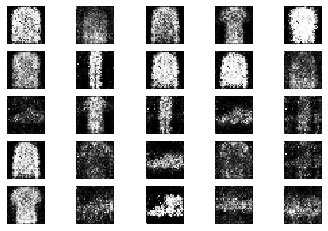

1601 [D loss: 0.596344, acc.: 71.88%] [G loss: 0.852780]
1602 [D loss: 0.632745, acc.: 60.94%] [G loss: 0.916243]
1603 [D loss: 0.672460, acc.: 64.06%] [G loss: 0.880011]
1604 [D loss: 0.567730, acc.: 70.31%] [G loss: 0.903353]
1605 [D loss: 0.636924, acc.: 68.75%] [G loss: 0.956466]
1606 [D loss: 0.653026, acc.: 59.38%] [G loss: 0.882789]
1607 [D loss: 0.622432, acc.: 67.19%] [G loss: 0.890835]
1608 [D loss: 0.664358, acc.: 59.38%] [G loss: 0.891434]
1609 [D loss: 0.636210, acc.: 59.38%] [G loss: 0.921474]
1610 [D loss: 0.646685, acc.: 57.81%] [G loss: 1.001578]
1611 [D loss: 0.613276, acc.: 65.62%] [G loss: 0.955685]
1612 [D loss: 0.626891, acc.: 62.50%] [G loss: 0.965631]
1613 [D loss: 0.605205, acc.: 67.19%] [G loss: 0.894097]
1614 [D loss: 0.657185, acc.: 56.25%] [G loss: 0.825453]
1615 [D loss: 0.628643, acc.: 62.50%] [G loss: 0.863167]
1616 [D loss: 0.651427, acc.: 60.94%] [G loss: 0.793709]
1617 [D loss: 0.673277, acc.: 56.25%] [G loss: 0.824397]
1618 [D loss: 0.634551, acc.: 6

1746 [D loss: 0.598249, acc.: 62.50%] [G loss: 0.933515]
1747 [D loss: 0.614566, acc.: 67.19%] [G loss: 0.994371]
1748 [D loss: 0.628697, acc.: 60.94%] [G loss: 0.923587]
1749 [D loss: 0.595547, acc.: 64.06%] [G loss: 0.983511]
1750 [D loss: 0.637669, acc.: 65.62%] [G loss: 0.912271]
1751 [D loss: 0.665250, acc.: 62.50%] [G loss: 0.919240]
1752 [D loss: 0.663278, acc.: 59.38%] [G loss: 0.942099]
1753 [D loss: 0.739630, acc.: 51.56%] [G loss: 1.069049]
1754 [D loss: 0.587807, acc.: 68.75%] [G loss: 0.952645]
1755 [D loss: 0.621885, acc.: 68.75%] [G loss: 0.997593]
1756 [D loss: 0.615421, acc.: 64.06%] [G loss: 0.918596]
1757 [D loss: 0.616089, acc.: 70.31%] [G loss: 0.902213]
1758 [D loss: 0.608701, acc.: 64.06%] [G loss: 0.942958]
1759 [D loss: 0.648710, acc.: 57.81%] [G loss: 0.915370]
1760 [D loss: 0.593808, acc.: 71.88%] [G loss: 0.873898]
1761 [D loss: 0.678018, acc.: 60.94%] [G loss: 0.830939]
1762 [D loss: 0.647979, acc.: 67.19%] [G loss: 0.906257]
1763 [D loss: 0.689935, acc.: 5

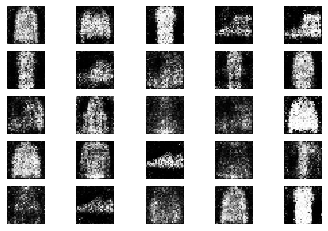

1801 [D loss: 0.671884, acc.: 59.38%] [G loss: 0.951546]
1802 [D loss: 0.637174, acc.: 59.38%] [G loss: 0.957211]
1803 [D loss: 0.619336, acc.: 65.62%] [G loss: 0.953556]
1804 [D loss: 0.644086, acc.: 59.38%] [G loss: 0.883945]
1805 [D loss: 0.599076, acc.: 71.88%] [G loss: 0.956454]
1806 [D loss: 0.636422, acc.: 62.50%] [G loss: 0.885333]
1807 [D loss: 0.637588, acc.: 59.38%] [G loss: 0.834837]
1808 [D loss: 0.662208, acc.: 57.81%] [G loss: 0.967916]
1809 [D loss: 0.584116, acc.: 65.62%] [G loss: 0.980896]
1810 [D loss: 0.568167, acc.: 67.19%] [G loss: 1.008517]
1811 [D loss: 0.599553, acc.: 67.19%] [G loss: 0.923123]
1812 [D loss: 0.544536, acc.: 81.25%] [G loss: 0.951917]
1813 [D loss: 0.634762, acc.: 65.62%] [G loss: 1.020339]
1814 [D loss: 0.563682, acc.: 67.19%] [G loss: 0.908677]
1815 [D loss: 0.603438, acc.: 70.31%] [G loss: 0.903558]
1816 [D loss: 0.648222, acc.: 62.50%] [G loss: 0.997129]
1817 [D loss: 0.658944, acc.: 57.81%] [G loss: 0.921388]
1818 [D loss: 0.627652, acc.: 6

1946 [D loss: 0.624820, acc.: 59.38%] [G loss: 0.904054]
1947 [D loss: 0.594542, acc.: 65.62%] [G loss: 0.929451]
1948 [D loss: 0.623737, acc.: 59.38%] [G loss: 0.951151]
1949 [D loss: 0.645368, acc.: 70.31%] [G loss: 0.947355]
1950 [D loss: 0.602722, acc.: 65.62%] [G loss: 0.924016]
1951 [D loss: 0.625604, acc.: 64.06%] [G loss: 0.988977]
1952 [D loss: 0.557173, acc.: 75.00%] [G loss: 0.958749]
1953 [D loss: 0.656916, acc.: 59.38%] [G loss: 0.872035]
1954 [D loss: 0.549152, acc.: 71.88%] [G loss: 0.979508]
1955 [D loss: 0.768128, acc.: 45.31%] [G loss: 0.818543]
1956 [D loss: 0.584485, acc.: 67.19%] [G loss: 0.865514]
1957 [D loss: 0.612470, acc.: 64.06%] [G loss: 0.876349]
1958 [D loss: 0.612194, acc.: 62.50%] [G loss: 0.957603]
1959 [D loss: 0.650694, acc.: 59.38%] [G loss: 0.907866]
1960 [D loss: 0.634512, acc.: 57.81%] [G loss: 0.900166]
1961 [D loss: 0.657196, acc.: 64.06%] [G loss: 0.925187]
1962 [D loss: 0.598248, acc.: 71.88%] [G loss: 0.941745]
1963 [D loss: 0.664759, acc.: 6

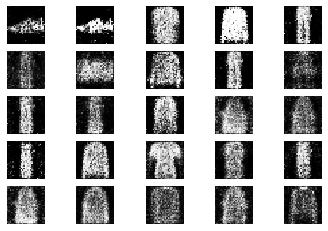

2001 [D loss: 0.739714, acc.: 53.12%] [G loss: 0.950555]
2002 [D loss: 0.688735, acc.: 57.81%] [G loss: 0.755147]
2003 [D loss: 0.560865, acc.: 68.75%] [G loss: 0.888544]
2004 [D loss: 0.692767, acc.: 62.50%] [G loss: 0.865722]
2005 [D loss: 0.645105, acc.: 59.38%] [G loss: 0.904409]
2006 [D loss: 0.544782, acc.: 73.44%] [G loss: 0.956181]
2007 [D loss: 0.675025, acc.: 59.38%] [G loss: 0.926486]
2008 [D loss: 0.645273, acc.: 62.50%] [G loss: 0.857530]
2009 [D loss: 0.647846, acc.: 60.94%] [G loss: 0.929330]
2010 [D loss: 0.536965, acc.: 73.44%] [G loss: 0.832984]
2011 [D loss: 0.669592, acc.: 50.00%] [G loss: 0.957568]
2012 [D loss: 0.580184, acc.: 65.62%] [G loss: 0.930188]
2013 [D loss: 0.500140, acc.: 79.69%] [G loss: 0.916815]
2014 [D loss: 0.683031, acc.: 65.62%] [G loss: 0.890839]
2015 [D loss: 0.665497, acc.: 60.94%] [G loss: 0.844150]
2016 [D loss: 0.670621, acc.: 59.38%] [G loss: 0.866289]
2017 [D loss: 0.621252, acc.: 65.62%] [G loss: 0.871188]
2018 [D loss: 0.649746, acc.: 6

2146 [D loss: 0.623712, acc.: 62.50%] [G loss: 0.918142]
2147 [D loss: 0.627175, acc.: 65.62%] [G loss: 0.969295]
2148 [D loss: 0.631583, acc.: 60.94%] [G loss: 0.940612]
2149 [D loss: 0.617285, acc.: 64.06%] [G loss: 0.954262]
2150 [D loss: 0.596098, acc.: 70.31%] [G loss: 0.909432]
2151 [D loss: 0.597082, acc.: 67.19%] [G loss: 0.835263]
2152 [D loss: 0.610319, acc.: 68.75%] [G loss: 0.950119]
2153 [D loss: 0.645941, acc.: 60.94%] [G loss: 0.780429]
2154 [D loss: 0.627928, acc.: 70.31%] [G loss: 0.957017]
2155 [D loss: 0.561254, acc.: 65.62%] [G loss: 0.985887]
2156 [D loss: 0.618531, acc.: 67.19%] [G loss: 1.004971]
2157 [D loss: 0.565163, acc.: 75.00%] [G loss: 0.929615]
2158 [D loss: 0.512720, acc.: 73.44%] [G loss: 0.855837]
2159 [D loss: 0.716644, acc.: 48.44%] [G loss: 0.836641]
2160 [D loss: 0.620361, acc.: 60.94%] [G loss: 0.930306]
2161 [D loss: 0.665743, acc.: 65.62%] [G loss: 0.948726]
2162 [D loss: 0.621445, acc.: 62.50%] [G loss: 1.030358]
2163 [D loss: 0.625927, acc.: 6

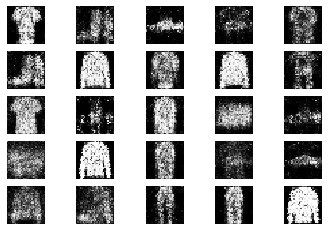

2201 [D loss: 0.579953, acc.: 70.31%] [G loss: 0.857312]
2202 [D loss: 0.590384, acc.: 65.62%] [G loss: 0.794255]
2203 [D loss: 0.666196, acc.: 57.81%] [G loss: 0.890886]
2204 [D loss: 0.639334, acc.: 62.50%] [G loss: 0.952039]
2205 [D loss: 0.699553, acc.: 50.00%] [G loss: 0.826900]
2206 [D loss: 0.680014, acc.: 56.25%] [G loss: 0.836043]
2207 [D loss: 0.629197, acc.: 59.38%] [G loss: 0.960357]
2208 [D loss: 0.669238, acc.: 53.12%] [G loss: 0.992935]
2209 [D loss: 0.644924, acc.: 67.19%] [G loss: 0.930673]
2210 [D loss: 0.663210, acc.: 59.38%] [G loss: 0.824719]
2211 [D loss: 0.654383, acc.: 62.50%] [G loss: 0.886831]
2212 [D loss: 0.647525, acc.: 67.19%] [G loss: 0.940315]
2213 [D loss: 0.724286, acc.: 54.69%] [G loss: 0.825648]
2214 [D loss: 0.625140, acc.: 62.50%] [G loss: 0.878266]
2215 [D loss: 0.641097, acc.: 64.06%] [G loss: 0.915706]
2216 [D loss: 0.594578, acc.: 65.62%] [G loss: 0.935374]
2217 [D loss: 0.598516, acc.: 70.31%] [G loss: 0.997293]
2218 [D loss: 0.606229, acc.: 6

2346 [D loss: 0.572140, acc.: 71.88%] [G loss: 0.916388]
2347 [D loss: 0.626894, acc.: 70.31%] [G loss: 0.914461]
2348 [D loss: 0.567311, acc.: 79.69%] [G loss: 0.899254]
2349 [D loss: 0.646281, acc.: 56.25%] [G loss: 0.859821]
2350 [D loss: 0.628781, acc.: 67.19%] [G loss: 0.909350]
2351 [D loss: 0.593587, acc.: 67.19%] [G loss: 1.000262]
2352 [D loss: 0.671187, acc.: 59.38%] [G loss: 0.934194]
2353 [D loss: 0.615772, acc.: 60.94%] [G loss: 0.917279]
2354 [D loss: 0.633662, acc.: 60.94%] [G loss: 0.865849]
2355 [D loss: 0.694120, acc.: 54.69%] [G loss: 0.849127]
2356 [D loss: 0.621307, acc.: 65.62%] [G loss: 0.922686]
2357 [D loss: 0.654767, acc.: 68.75%] [G loss: 0.941506]
2358 [D loss: 0.625310, acc.: 70.31%] [G loss: 0.924501]
2359 [D loss: 0.605021, acc.: 70.31%] [G loss: 0.947495]
2360 [D loss: 0.622057, acc.: 59.38%] [G loss: 1.003374]
2361 [D loss: 0.633318, acc.: 57.81%] [G loss: 1.028931]
2362 [D loss: 0.616215, acc.: 67.19%] [G loss: 0.944997]
2363 [D loss: 0.626978, acc.: 6

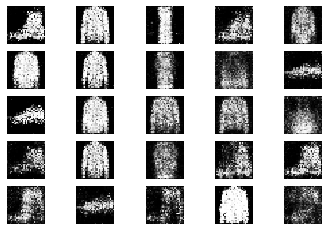

2401 [D loss: 0.663910, acc.: 53.12%] [G loss: 0.933139]
2402 [D loss: 0.587351, acc.: 71.88%] [G loss: 0.963246]
2403 [D loss: 0.642944, acc.: 60.94%] [G loss: 0.919446]
2404 [D loss: 0.611300, acc.: 62.50%] [G loss: 1.029530]
2405 [D loss: 0.626422, acc.: 71.88%] [G loss: 0.969895]
2406 [D loss: 0.625484, acc.: 57.81%] [G loss: 0.932086]
2407 [D loss: 0.747366, acc.: 51.56%] [G loss: 0.897352]
2408 [D loss: 0.623002, acc.: 60.94%] [G loss: 0.946024]
2409 [D loss: 0.628570, acc.: 62.50%] [G loss: 0.968642]
2410 [D loss: 0.639797, acc.: 67.19%] [G loss: 0.906781]
2411 [D loss: 0.626114, acc.: 65.62%] [G loss: 0.859275]
2412 [D loss: 0.678664, acc.: 54.69%] [G loss: 0.897407]
2413 [D loss: 0.631997, acc.: 73.44%] [G loss: 0.960429]
2414 [D loss: 0.592839, acc.: 70.31%] [G loss: 0.998093]
2415 [D loss: 0.628080, acc.: 64.06%] [G loss: 0.840590]
2416 [D loss: 0.661882, acc.: 62.50%] [G loss: 0.949900]
2417 [D loss: 0.518156, acc.: 79.69%] [G loss: 0.931949]
2418 [D loss: 0.651611, acc.: 6

2548 [D loss: 0.590119, acc.: 70.31%] [G loss: 0.874012]
2549 [D loss: 0.624018, acc.: 65.62%] [G loss: 0.791845]
2550 [D loss: 0.689127, acc.: 53.12%] [G loss: 0.854502]
2551 [D loss: 0.708179, acc.: 54.69%] [G loss: 0.889816]
2552 [D loss: 0.578520, acc.: 68.75%] [G loss: 0.988230]
2553 [D loss: 0.770925, acc.: 51.56%] [G loss: 0.851577]
2554 [D loss: 0.654050, acc.: 67.19%] [G loss: 0.929423]
2555 [D loss: 0.625804, acc.: 67.19%] [G loss: 0.893705]
2556 [D loss: 0.620289, acc.: 64.06%] [G loss: 0.985559]
2557 [D loss: 0.599974, acc.: 73.44%] [G loss: 0.782088]
2558 [D loss: 0.700461, acc.: 60.94%] [G loss: 0.824512]
2559 [D loss: 0.536762, acc.: 75.00%] [G loss: 0.921941]
2560 [D loss: 0.644908, acc.: 59.38%] [G loss: 0.779097]
2561 [D loss: 0.679238, acc.: 57.81%] [G loss: 0.905788]
2562 [D loss: 0.628845, acc.: 60.94%] [G loss: 0.830393]
2563 [D loss: 0.680258, acc.: 57.81%] [G loss: 0.908447]
2564 [D loss: 0.578980, acc.: 71.88%] [G loss: 0.846766]
2565 [D loss: 0.662486, acc.: 5

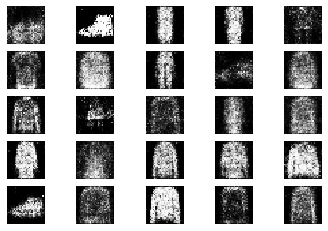

2601 [D loss: 0.631873, acc.: 71.88%] [G loss: 0.866861]
2602 [D loss: 0.679473, acc.: 60.94%] [G loss: 0.874880]
2603 [D loss: 0.656648, acc.: 56.25%] [G loss: 0.877946]
2604 [D loss: 0.646470, acc.: 62.50%] [G loss: 0.907001]
2605 [D loss: 0.610542, acc.: 67.19%] [G loss: 0.914512]
2606 [D loss: 0.638417, acc.: 67.19%] [G loss: 0.830207]
2607 [D loss: 0.656389, acc.: 60.94%] [G loss: 1.005350]
2608 [D loss: 0.631156, acc.: 60.94%] [G loss: 0.919096]
2609 [D loss: 0.700822, acc.: 59.38%] [G loss: 0.916760]
2610 [D loss: 0.707553, acc.: 56.25%] [G loss: 0.817515]
2611 [D loss: 0.779726, acc.: 46.88%] [G loss: 0.969941]
2612 [D loss: 0.656392, acc.: 56.25%] [G loss: 0.896006]
2613 [D loss: 0.657749, acc.: 57.81%] [G loss: 0.905742]
2614 [D loss: 0.703306, acc.: 56.25%] [G loss: 0.933057]
2615 [D loss: 0.646705, acc.: 68.75%] [G loss: 0.945147]
2616 [D loss: 0.677742, acc.: 59.38%] [G loss: 0.935454]
2617 [D loss: 0.616149, acc.: 71.88%] [G loss: 0.840683]
2618 [D loss: 0.613159, acc.: 6

2749 [D loss: 0.585464, acc.: 71.88%] [G loss: 0.948506]
2750 [D loss: 0.600588, acc.: 67.19%] [G loss: 0.934420]
2751 [D loss: 0.635484, acc.: 60.94%] [G loss: 0.940395]
2752 [D loss: 0.561060, acc.: 71.88%] [G loss: 1.029973]
2753 [D loss: 0.636264, acc.: 68.75%] [G loss: 0.971727]
2754 [D loss: 0.570370, acc.: 64.06%] [G loss: 0.924292]
2755 [D loss: 0.563798, acc.: 78.12%] [G loss: 0.968548]
2756 [D loss: 0.589166, acc.: 68.75%] [G loss: 0.984920]
2757 [D loss: 0.623050, acc.: 67.19%] [G loss: 0.938554]
2758 [D loss: 0.617135, acc.: 62.50%] [G loss: 0.857316]
2759 [D loss: 0.671398, acc.: 59.38%] [G loss: 0.826151]
2760 [D loss: 0.597164, acc.: 67.19%] [G loss: 0.814392]
2761 [D loss: 0.677269, acc.: 60.94%] [G loss: 0.908705]
2762 [D loss: 0.588329, acc.: 73.44%] [G loss: 0.825623]
2763 [D loss: 0.647321, acc.: 67.19%] [G loss: 0.887305]
2764 [D loss: 0.642114, acc.: 60.94%] [G loss: 0.870589]
2765 [D loss: 0.628213, acc.: 65.62%] [G loss: 1.070991]
2766 [D loss: 0.610805, acc.: 6

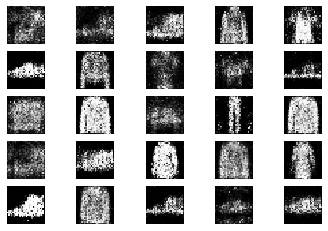

2801 [D loss: 0.617536, acc.: 62.50%] [G loss: 0.949245]
2802 [D loss: 0.578517, acc.: 71.88%] [G loss: 0.985716]
2803 [D loss: 0.657336, acc.: 59.38%] [G loss: 0.913224]
2804 [D loss: 0.631461, acc.: 64.06%] [G loss: 0.947255]
2805 [D loss: 0.756481, acc.: 48.44%] [G loss: 0.871316]
2806 [D loss: 0.604138, acc.: 71.88%] [G loss: 0.858556]
2807 [D loss: 0.697870, acc.: 54.69%] [G loss: 0.921459]
2808 [D loss: 0.655054, acc.: 51.56%] [G loss: 0.864773]
2809 [D loss: 0.575759, acc.: 76.56%] [G loss: 0.874908]
2810 [D loss: 0.674409, acc.: 53.12%] [G loss: 1.052317]
2811 [D loss: 0.740481, acc.: 62.50%] [G loss: 0.986630]
2812 [D loss: 0.656978, acc.: 59.38%] [G loss: 0.841158]
2813 [D loss: 0.633581, acc.: 56.25%] [G loss: 0.938672]
2814 [D loss: 0.586493, acc.: 70.31%] [G loss: 0.931221]
2815 [D loss: 0.660814, acc.: 56.25%] [G loss: 0.873135]
2816 [D loss: 0.657547, acc.: 64.06%] [G loss: 0.890061]
2817 [D loss: 0.632813, acc.: 54.69%] [G loss: 1.039232]
2818 [D loss: 0.598544, acc.: 7

2946 [D loss: 0.674298, acc.: 51.56%] [G loss: 0.926937]
2947 [D loss: 0.628636, acc.: 62.50%] [G loss: 0.937315]
2948 [D loss: 0.676509, acc.: 57.81%] [G loss: 0.929834]
2949 [D loss: 0.685248, acc.: 59.38%] [G loss: 1.024242]
2950 [D loss: 0.605129, acc.: 59.38%] [G loss: 0.890285]
2951 [D loss: 0.694068, acc.: 54.69%] [G loss: 0.930828]
2952 [D loss: 0.636095, acc.: 56.25%] [G loss: 0.972698]
2953 [D loss: 0.592930, acc.: 64.06%] [G loss: 0.921643]
2954 [D loss: 0.681548, acc.: 60.94%] [G loss: 0.943720]
2955 [D loss: 0.627974, acc.: 64.06%] [G loss: 0.862113]
2956 [D loss: 0.585508, acc.: 67.19%] [G loss: 0.881195]
2957 [D loss: 0.652714, acc.: 59.38%] [G loss: 0.996242]
2958 [D loss: 0.623919, acc.: 70.31%] [G loss: 0.928762]
2959 [D loss: 0.610374, acc.: 68.75%] [G loss: 0.984862]
2960 [D loss: 0.642109, acc.: 59.38%] [G loss: 0.928834]
2961 [D loss: 0.688280, acc.: 56.25%] [G loss: 0.981091]
2962 [D loss: 0.697866, acc.: 53.12%] [G loss: 0.893510]
2963 [D loss: 0.645962, acc.: 5

In [9]:
gn=GAN()

gn.train(epochs=3000, batch_size=32, sample_interval=200)